# Synthetic data generation for campaign effectiveness

We will be making use of the data from https://www.kaggle.com/datasets/conorsully1/credit-score?resource=download for saving and https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets?select=test.csv for campaign.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
original = pd.read_csv("../data/processed/BankChurners_cleaned.csv")
campaign = pd.read_csv("../data/raw/campaign_data.csv", sep = ';')
sav = pd.read_csv("../data/raw/credit_score.csv")

In [3]:
# Checking for duplicates
campaign_duplicates = campaign.duplicated()
sav_duplicates = sav.duplicated()

# Display the number of duplicate rows, if any
print(f"Number of duplicate rows in 'campaign': {campaign_duplicates.sum()}")
print(f"Number of duplicate rows in 'sav': {sav_duplicates.sum()}")

Number of duplicate rows in 'campaign': 0
Number of duplicate rows in 'sav': 0


# 1. Campaign data

Data that will be added:

- `duration`: last contact duration, in seconds (numeric) --> `Duration_of_Contact`
- `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact) --> `Number_of_Contacts_Made`
- `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted) --> `Last_Contact_Made`
- `y`: has the client subscribed a term deposit? (binary: "yes","no") --> `Outcome`

## 1.1 Feature selection

In [4]:
# similar columns: education, marital, age
common_features = ['education', 'marital', 'age']

ori = original.copy()
ori['education'] = ori['Education_Level']
ori['education'] = ori['education'].replace(
    {'Doctorate': 'tertiary',
     'Post-Graduate': 'tertiary',
     'Graduate': 'tertiary',
     'College': 'secondary',
     'High School': 'secondary', 
     'Uneducated': 'primary'})

ori['marital'] = ori['Marital_Status']
ori['marital'] = ori['marital'].replace(
    {'Married': 'married',
     'Single': 'single',
     'Divorced': 'divorced'})

ori['age'] = ori['Customer_Age']

In [5]:
# d/b of duration
duration_db = (
    campaign.groupby(common_features)['duration']
    .value_counts(normalize = True)
    .unstack(fill_value = 0)
)

# d/b of campaign
campaign_db = (
    campaign.groupby(common_features)['campaign']
    .value_counts(normalize = True)
    .unstack(fill_value = 0)
)

# d/b of pdays
pdays_db = (
    campaign.groupby(common_features)['pdays']
    .value_counts(normalize = True)
    .unstack(fill_value = 0)
)

# d/b of y
campaign['y'] = campaign['y'].replace({'yes': 1, 'no': 0})
y_db = (
    campaign.groupby(common_features)['y']
    .mean()
    .reset_index()
)

/var/folders/0r/kk1hzrmn3gn15tq_k14nb0r00000gn/T/ipykernel_87040/2509053190.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  campaign['y'] = campaign['y'].replace({'yes': 1, 'no': 0})


## 1.2 Sampling

In [6]:
# generating synthetic features
def generate_synthetic_features(df, distribution, feature):
    synthetic_feature = []
    
    for _, row in df.iterrows():
        features = tuple(row[common_features])
        try:
            sample = np.random.choice(
                distribution.columns,
                p=distribution.loc[features].values
            )
        except KeyError: #incase the feature combination is missing
            sample = np.random.choice(distribution.columns)
            
        synthetic_feature.append(sample)
            
    return synthetic_feature

def generate_synthetic_outcome(df, distribution):
    synthetic_outcome = []
    
    for _, row in df.iterrows():
        features = tuple(row[common_features])
        matching_row = distribution.loc[(distribution[common_features] == features).all(axis=1)]
        
        if not matching_row.empty:
            prob_yes = matching_row['y'].values[0]
            sample = np.random.choice([0, 1], p=[1 - prob_yes, prob_yes])
        else:
            sample = np.random.choice([0, 1])
        
        synthetic_outcome.append(sample)
    
    return synthetic_outcome

# generating the data
np.random.seed(3101)
original['Duration_of_Contact'] = generate_synthetic_features(ori, duration_db, 'duration')
original['Num_of_Contacts_Made'] = generate_synthetic_features(ori, campaign_db, 'campaign')
original['Last_Contacted'] = generate_synthetic_features(ori, pdays_db, 'pdays')
original['Outcome'] = generate_synthetic_outcome(ori, y_db)
original.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Month_with_bank,...,Months_Inactive_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Trans_Amt,Total_Trans_Count,Avg_Utilization_Ratio,Duration_of_Contact,Num_of_Contacts_Made,Last_Contacted,Outcome
0,768805383,1,45,1,3,High School,1,2,1,39,...,1,12691.0,777,1144,42,0.061,1101,27,364,1
1,818770008,1,49,0,5,Graduate,0,4,1,44,...,1,8256.0,864,1291,33,0.105,864,5,391,0
2,713982108,1,51,1,3,Graduate,1,3,1,36,...,1,3418.0,0,1887,20,0.000,1205,63,394,1
3,709106358,1,40,1,3,Uneducated,1,2,1,21,...,1,4716.0,0,816,28,0.000,701,32,456,0
4,713061558,1,44,1,2,Graduate,1,1,1,36,...,1,4010.0,1247,1088,24,0.311,1859,31,310,1


# 2 Savings

We will be generating synthetic data 'saving' base on the sav dataset. Since savings are usually highly correlated to income, we will make use of income to make some decisions(clustering).

## 2.1 Data cleaning

In [7]:
# convert income into income category then one-hot encoding
bins = [0, 40000, 60000, 80000, 120000, float('inf')]
labels = ['Less than 40', '40 - 60', '60 - 80', '80 - 120', '120 +']
sav['Income_Category'] = pd.cut(sav['INCOME'], bins = bins, labels = labels, right = False)
sav = pd.get_dummies(sav, columns=['Income_Category'], drop_first=True)

## 2.2 Clustering

/opt/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args

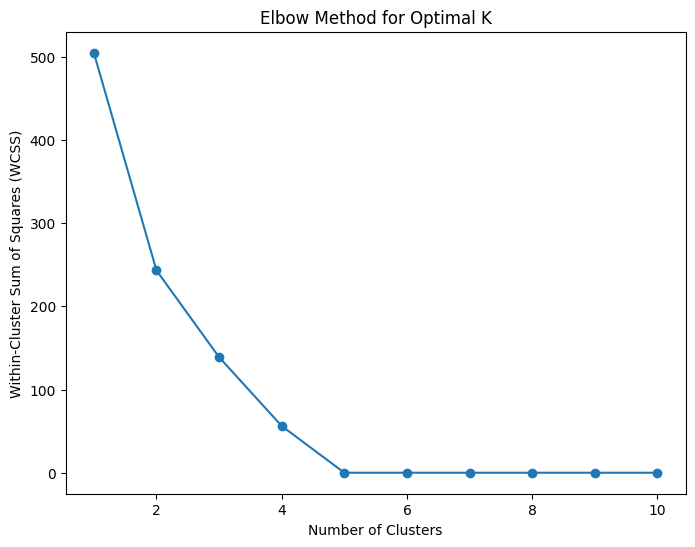

In [8]:
features = sav[['Income_Category_40 - 60', 'Income_Category_60 - 80', 'Income_Category_80 - 120', 'Income_Category_120 +']]

# Elbow method to find the optimal number of clusters
cluster_range = range(1, 11)
wcss = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()


In [9]:
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=42)
sav['Cluster'] = kmeans.fit_predict(features)

# Calculate mean and standard deviation for savings in each cluster
cluster_stats = sav.groupby('Cluster')['SAVINGS'].agg(['mean', 'std']).reset_index()
cluster_stats.columns = ['Cluster', 'Mean', 'SD']

## 2.2 Sampling

In [10]:
# Define a function to sample synthetic savings
def sample_savings(cluster):
    """Generates synthetic savings based on the cluster's mean and standard deviation."""
    mean = cluster_stats.loc[cluster_stats['Cluster'] == cluster, 'Mean'].values[0]
    std = cluster_stats.loc[cluster_stats['Cluster'] == cluster, 'SD'].values[0]
    return round(np.maximum(np.random.normal(mean, std), 0), 2)  # Ensure non-negative values


In [11]:
# Apply synthetic savings generation to 'sav' data
sav['Synthetic_Savings'] = sav['Cluster'].apply(sample_savings)

# Apply clustering and synthetic savings generation to 'original' data
original = pd.get_dummies(original, columns=['Income_Category'], drop_first=False)
original['Cluster'] = kmeans.predict(original[['Income_Category_40 - 60', 'Income_Category_60 - 80', 'Income_Category_80 - 120', 'Income_Category_120 +']])
original['Savings'] = original['Cluster'].apply(sample_savings)

KeyError: "None of [Index(['Income_Category_40 - 60', 'Income_Category_60 - 80',\n       'Income_Category_80 - 120', 'Income_Category_120 +'],\n      dtype='object')] are in the [columns]"

# 2. Exporting to data/processed

In [33]:
features = ['CLIENTNUM', 'Savings','Duration_of_Contact', 'Num_of_Contacts_Made','Last_Contacted','Outcome']
final_df = original.loc[:,features]
final_df.to_csv('../data/processed/Campaign.csv', index=False)